<a href="https://colab.research.google.com/github/tjdndwls/sw/blob/main/swproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **transformers, konlpy 드라이브에서 불러오기**

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

# **라이브러리 함수 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, f1_score

from collections import Counter
from sklearn.model_selection import train_test_split
from konlpy.tag import Komoran

import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import random
import time
import datetime

# **review 데이터 읽어오기**

In [ ]:
train = pd.read_table('/content/sample_data/ratings_train.txt')
test = pd.read_table('/content/sample_data/ratings_test.txt')

In [ ]:
train.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


### **라벨별 데이터 수**

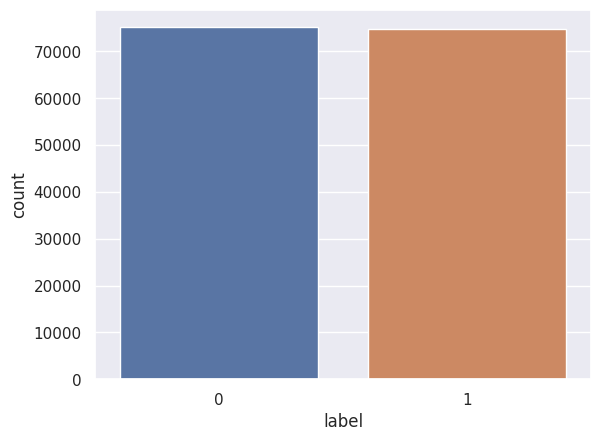

In [ ]:
sns.set_theme(style = "darkgrid")
ax = sns.countplot(x= "label", data = train)

### **중복된 데이터 확인 및 제거**

In [ ]:
train['document'].nunique(), train['label'].nunique()

(146182, 2)

In [ ]:
train.drop_duplicates(subset=['document'], inplace=True)

### **NULL값을 가지는 문장 제거**

In [ ]:
print(train.isnull().sum())

id          0
document    1
label       0
dtype: int64


### **한글과 공백을 제외한 문자 제거**

In [ ]:
train = train.dropna(how = 'any')
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'] = train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['document'].replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')

<ipython-input-38-e4d562bf50eb>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-38-e4d562bf50eb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['document'] = train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


### **test data에 대해 적용**

In [ ]:
test.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['document'] = test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거

<ipython-input-39-af51f3160773>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-39-af51f3160773>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test['document'] = test['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


# **gpu 확인**

In [ ]:
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

0


# **문장 구분하기 위해 CLS SEP 추가**

In [ ]:
train.shape

(145393, 3)

In [ ]:
sentences = ["[CLS] " + str(s) + " [SEP]" for s in train.document]

In [ ]:
len(sentences)

145393

In [ ]:
sentences[:5]

['[CLS] 아 더빙 진짜 짜증나네요 목소리 [SEP]',
 '[CLS] 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나 [SEP]',
 '[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]',
 '[CLS] 교도소 이야기구먼 솔직히 재미는 없다평점 조정 [SEP]',
 '[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']

In [ ]:
labels = train['label'].values

# **WordPiece로 단어 토큰화**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in sentences]
print(tokenized_texts[5])

['[CLS]', '막', '걸', '##음', '##마', '[UNK]', '세', '##부터', '초', '##등학교', '학', '##년', '##생', '##인', '[UNK]', '아', '##까', '##움', '[SEP]']


# **문장 최대 길이 설정 및 패딩 적용**

### **패딩으로 문장의 최대 길이 통일하여 병렬 처리 지원**

In [ ]:
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   9074, 119005,   9708, 119235,   9715, 119230,
        16439,  77884,  48549,   9284,  22333,  12692,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
input_ids.size

18610304

# **어텐션 마스크 적용**

### **패딩된 값과 패딩되지 않은 단어 구분하는 용도**

In [ ]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# **train/validation으로 분리**

### **validation set을 적용하여 Overfitting 방지**

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = \
train_test_split(input_ids, labels, stratify= labels, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.1)

### **numpy ndarray형태인 input, label, mask 등을**
### **torch tensor로 변환**

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

### **배치 사이즈 설정 및 데이터로더 설정**

In [ ]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

### **train과 마찬가지로 test 전처리**

In [ ]:
sentences = test['document']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = test['label'].values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)


### **GPU 할당**

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

No GPU available, using the CPU instead.


### **BertForSequenceClassification 모듈 이용**

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: ignored

### **학습률, epochs, 스케줄러 설정**

In [ ]:
# 옵티마이저 설정
#경사하강법에서 변형된 여러 종류 중 하나인 Adamw 옵티마이저 적
optimizer = AdamW(model.parameters(),
                  lr = 0.001, # 학습률
                  eps = 0.000001 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# 학습률을 점차 감소시키며 적용하는 방식
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

### **accuracy함수, 시간표시함수**

In [ ]:
# 정확도 계산 함수
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    return accuracy

# F1 스코어 계산 함수
def calculate_f1_score(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    f1 = f1_score(labels_flat, pred_flat, average='binary')
    return f1

 # 정밀도 계산 함수
def calculate_precision(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    precision = precision_score(labels_flat, pred_flat, average='binary')
    return precision

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

### **학습 실행**

In [ ]:
# 재현을 위해 랜덤시드 고정, 42가 일반적
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):

    #train data 학습

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # train모드로 전환하는 함수 호출
    model.train()

    # 데이터로더에서 배치 사이즈 만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 작업(모델에 배치에서 추출한 data 적용)
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # transformers 라이브러리의 [0]은 loss를 나타냄
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # Gradient clipping 적용(기울기값이 임계값 넘어갈 시 clipping해줌)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    #validation에 대해 학습

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변환하는 함수 호출
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 평가모드에선 그래디언트 계산 x
        with torch.no_grad():
            # Forward 수행
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = calculate_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        tmp_f1 = calculate_f1_score(logits, label_ids)
        eval_f1 += tmp_f1
        tmp_precision = calculate_precision(logits, label_ids)
        eval_precision += tmp_precision
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  F1 Score: {0:.2f}".format(eval_f1 / nb_eval_steps))
    print("  Precision: {0:.2f}".format(eval_precision / nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

### **테스트셋 평가**

In [ ]:


#시작 시간 설정
t0 = time.time()

# 평가모드로 전환하는 함수 호출
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함(평가모드)
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = calculate_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    tmp_f1 = calculate_f1_score(logits, label_ids)
    eval_f1 += tmp_f1
    tmp_precision = calculate_precision(logits, label_ids)
    eval_precision += tmp_precision
    nb_eval_steps += 1

print("")


### **최종 평가 지표**

In [ ]:
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  F1 Score: {0:.2f}".format(eval_f1 / nb_eval_steps))
print("  Precision: {0:.2f}".format(eval_precision / nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))